# Code test

This jupyter notebook is for testing the functions for some analytical solvable cases.

## Libraries

In [85]:
# Library for linear algebra
import numpy as np
from numpy import linalg
from numpy import random
# Library and functions for the plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
# Library for precompiled (and faster) code
import numba as numba
from numba import njit
# Library for optimization
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
# Library for error function
from scipy import special
# Library for curve fitting
from scipy.optimize import curve_fit

## 1 D test

In [2]:
@njit(fastmath=True)
def state(q): #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    state = 0  # Transition state
    if q > 1.0:
        # Product state
        state = 1
    if q < 0.0:
        # Reactant state
        state = -1
    return state

In [3]:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, q0 = None, c = [0.5,0.5], R =0.2, dt = 0.002, KbT = 0.15, kr = 300, isteps = 10000):
    # Define preliminary variables
    q = np.empty(isteps, dtype=np.float64)
    M = np.empty((isteps,2,2), dtype=np.float64)
    q[0] = 0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i])
        # Linear combination of committors
        z0 = Guess1(q[i])
        z1 = Guess2(q[i])
        z = c[0]*z0+c[1]*z1
        # Gradient components of the committors
        dGx1 = dGuess1(q[i])
        dGx2 = dGuess2(q[i])
        # Matrix M
        M[i,0,0] = dGx1**2
        M[i,1,0] = dGx2*dGx1
        M[i,0,1] = dGx1*dGx2
        M[i,1,1] = dGx2**2
        #print(z0, z1, z[i])
        if z > zmax:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)+kr*(c[0]*dGx1 + c[1]*dGx2)*(zmax - z)*dt
        i += 1
        s = state(q[i])
        
    M *= np.sqrt(2.0*KbT)  # This line technically is not needed because later we rescale everything. Kept for consistency
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty(1, dtype=np.float64)
        out[0] = 0.0
        outM = np.empty((1, 2, 2), dtype=np.float64)
        outM[0,0,0] = 0.0
        outM[0,1,0] = 0.0
        outM[0,0,1] = 0.0
        outM[0,1,1] = 0.0
        return out, outM
        
    return q[j+1:i-1], M[j+1:i-1,:,:]

In [20]:
def Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], R = 0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M = LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
        del traj, M
    
    # Evaluation of M
    M = np.zeros((2,2), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    
    # Minimization part
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=LinearConstraint([1.0, 1.0], 1.0, 1.0),
               options={'verbose': 0}, bounds=Bounds([0.0, 0.0], [1.0, 1.0]))
    
    
    return np.array(cout.x)

In [5]:
def Self_consistent(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], R = 0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000, jsteps = 1000, ksteps = 30, alpha = 0.5):       
    cout = np.empty((ksteps, 2), dtype=np.float64)
    # Save the initial conditions
    cout[0,0] = c[0]
    cout[0,1] = c[1]
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

### First test: no potential

In [6]:
@njit(fastmath=True)
def potential(q):
    return 0.0

@njit(fastmath=True)
def force(q):
    return 0.0

In [7]:
@njit(fastmath=True)
def qLin(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return q
    
@njit(fastmath=True)
def dqLin(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 1.0
   
@njit(fastmath=True)
def qQuadr(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return q**2

@njit(fastmath=True)
def dqQuadr(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 2*q
 
@njit(fastmath=True)
def qCub(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return q**3

@njit(fastmath=True)
def dqCub(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 3*(q**2)
    
@njit(fastmath=True)
def qExp(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return (np.exp(q)-1.0)/(np.exp(1.0)-1.0)

@njit(fastmath=True)
def dqExp(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return np.exp(q)/(np.exp(1.0)-1.0)
    
@njit(fastmath=True)
def qLog(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return np.log(q+1.0)/np.log(2)

@njit(fastmath=True)
def dqLog(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 1.0/(np.log(2)*(1.0+q))
    
@njit(fastmath=True)
def qSqrt(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return np.sqrt(q)

@njit(fastmath=True)
def dqSqrt(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 1.0/(2.0*np.sqrt(q))

Plot of the different committors and their derivatives.

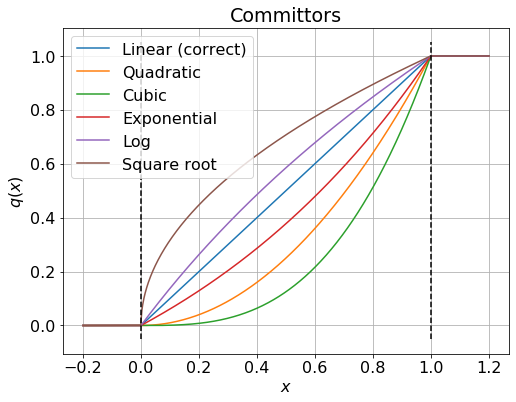

In [8]:
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    y[i] = qLin(x[i])
plt.plot(x,y, label ='Linear (correct)')
for i in range(len(x)):
    y[i] = qQuadr(x[i])
plt.plot(x,y, label ='Quadratic')
for i in range(len(x)):
    y[i] = qCub(x[i])
plt.plot(x,y, label ='Cubic')
for i in range(len(x)):
    y[i] = qExp(x[i])    
plt.plot(x,y, label ='Exponential')
for i in range(len(x)):
    y[i] = qLog(x[i])    
plt.plot(x,y, label ='Log')
for i in range(len(x)):
    y[i] = qSqrt(x[i])    
plt.plot(x,y, label ='Square root')

plt.plot(0.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.title('Committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

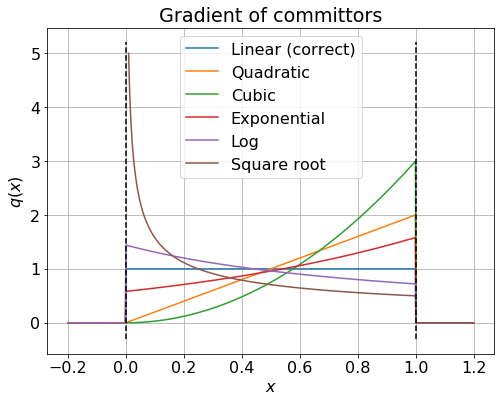

In [9]:
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    y[i] = dqLin(x[i])
plt.plot(x,y, label ='Linear (correct)')
for i in range(len(x)):
    y[i] = dqQuadr(x[i])
plt.plot(x,y, label ='Quadratic')
for i in range(len(x)):
    y[i] = dqCub(x[i])
plt.plot(x,y, label ='Cubic')
for i in range(len(x)):
    y[i] = dqExp(x[i])    
plt.plot(x,y, label ='Exponential')
for i in range(len(x)):
    y[i] = dqLog(x[i])    
plt.plot(x,y, label ='Log')
x = np.linspace(0.01,1.2,1000)
for i in range(len(x)):
    y[i] = dqSqrt(x[i])    
plt.plot(x,y, label ='Square root')
plt.plot(0.0*np.ones(2),np.linspace(-0.3,5.2,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.3,5.2,2),"k--")
plt.title('Gradient of committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

In [64]:
KR = 1000
KBT = 0.01
ctry = [1.0, 0.0]

Linear guess 

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


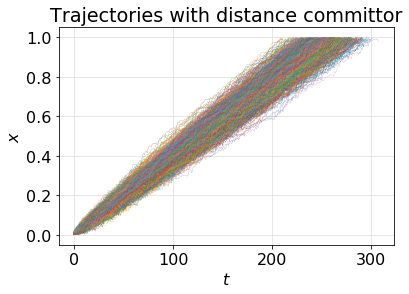

M
[[0.14142136 0.14142136]
 [0.14142136 0.14142136]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-65-0f4c20d31b6b>", line 41:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 1.39e-16, constraint violation: 0.00e+00, execution time: 0.023 s.
[0.5 0.5]

 Quadratic guess 

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


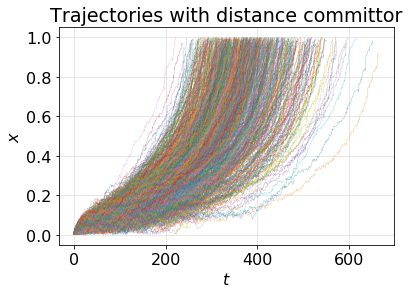

M
[[0.07880867 0.07880867]
 [0.07880867 0.07880867]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-65-0f4c20d31b6b>", line 113:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 1.11e-16, constraint violation: 0.00e+00, execution time: 0.015 s.
[0.5 0.5]

 Cubic guess 

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No r

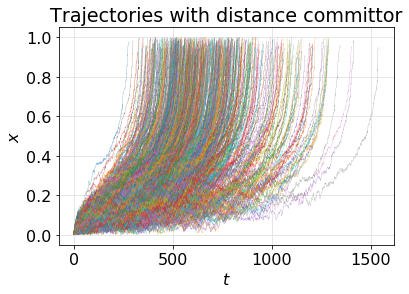

M
[[0.03905031 0.03905031]
 [0.03905031 0.03905031]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-65-0f4c20d31b6b>", line 185:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 4.16e-17, constraint violation: 0.00e+00, execution time: 0.049 s.
[0.5 0.5]

 Exp guess 

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


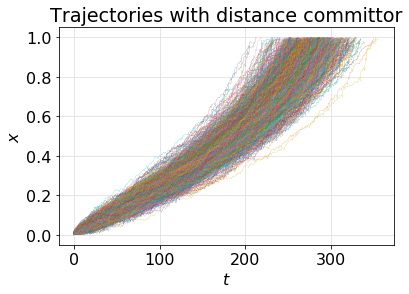

M
[[0.12247116 0.12247116]
 [0.12247116 0.12247116]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-65-0f4c20d31b6b>", line 257:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 1.39e-16, constraint violation: 0.00e+00, execution time: 0.033 s.
[0.5 0.5]

 Log guess 

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


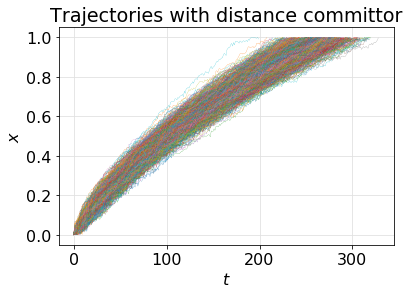

M
[[0.13156001 0.13156001]
 [0.13156001 0.13156001]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-65-0f4c20d31b6b>", line 331:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 5.55e-17, constraint violation: 0.00e+00, execution time: 0.01 s.
[0.5 0.5]

 Sqrt guess 

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


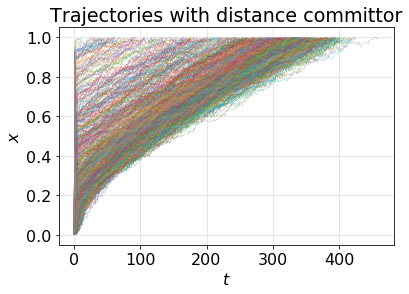

M
[[0.28809035 0.28809035]
 [0.28809035 0.28809035]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-65-0f4c20d31b6b>", line 405:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 2.22e-16, constraint violation: 0.00e+00, execution time: 0.014 s.
[0.5 0.5]


In [65]:
### Linear guess
print("Linear guess \n")
## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qLin, dGuess2 = dqLin, c = ctry,kr = KR, KbT = KBT)
    if traj[0] != 0:
        plt.plot(traj, linewidth=0.2)
        if tmp==0:
            trajLin = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajLin = np.concatenate((trajLin, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with distance committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ILin = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Quadratic guess
print("\n Quadratic guess \n")

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, c = ctry,kr = KR, KbT = KBT)
    if traj[0] != 0:
        plt.plot(traj, linewidth=0.2)
        if tmp==0:
            trajQuadr = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajQuadr = np.concatenate((trajQuadr, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with distance committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
IQuadr = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Cubic guess
print("\n Cubic guess \n")

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qCub, dGuess1 = dqCub, Guess2 = qCub, dGuess2 = dqCub, c = ctry,kr = KR, KbT = KBT)
    if traj[0] != 0:
        plt.plot(traj, linewidth=0.2)
        if tmp==0:
            trajCub = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajCub = np.concatenate((trajCub, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with distance committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ICub = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Exp guess
print("\n Exp guess \n")

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qExp, dGuess1 = dqExp, Guess2 = qExp, dGuess2 = dqExp, c = ctry,kr = KR, KbT = KBT)
    if traj[0] != 0:
        plt.plot(traj, linewidth=0.2)
        if tmp==0:
            trajExp = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajExp = np.concatenate((trajExp, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with distance committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
IExp = I(ctry,M)

## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)


### Log guess
print("\n Log guess \n")

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qLog, dGuess1 = dqLog, Guess2 = qLog, dGuess2 = dqLog, c = ctry,kr = KR, KbT = KBT)
    if traj[0] != 0:
        plt.plot(traj, linewidth=0.2)
        if tmp==0:
            trajLog = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajLog = np.concatenate((trajLog, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with distance committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ILog = I(ctry,M)

## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)


### Sqrt guess
print("\n Sqrt guess \n")

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qSqrt, dGuess1 = dqSqrt, Guess2 = qSqrt, dGuess2 = dqSqrt, c = ctry,kr = KR, KbT = KBT)
    if traj[0] != 0:
        plt.plot(traj, linewidth=0.2)
        if tmp==0:
            trajSqrt = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajSqrt = np.concatenate((trajSqrt, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with distance committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ISqrt = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

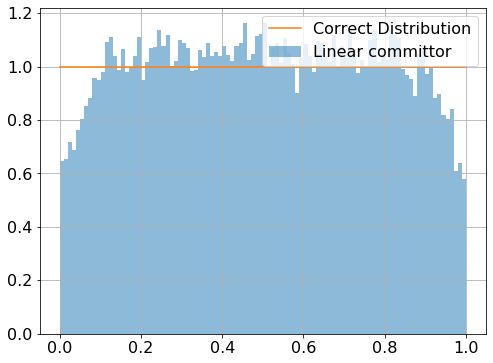

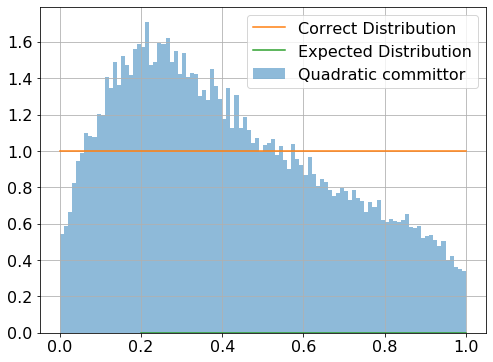

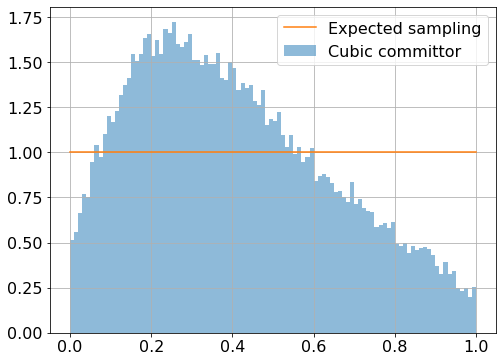

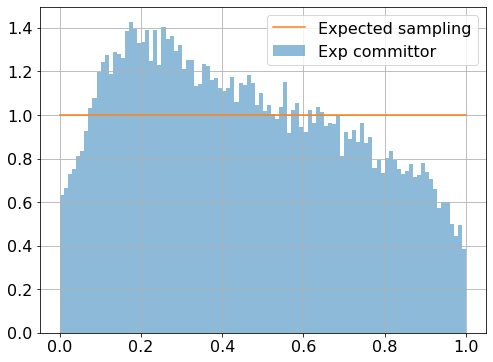

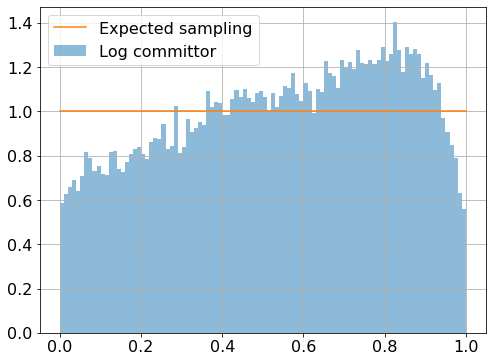

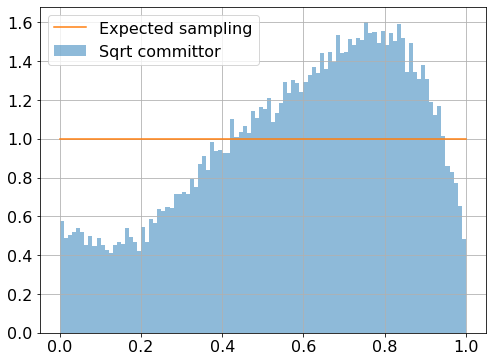

In [24]:
# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajLin, 100, density=True, alpha = 0.5, label = 'Linear committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,x*0+1, label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajQuadr, 100, density=True, alpha = 0.5, label = 'Quadratic committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,x*0+1, label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajCub, 100, density=True, alpha = 0.5, label = 'Cubic committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,x*0+1, label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajExp, 100, density=True, alpha = 0.5, label = 'Exp committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,x*0+1, label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajLog, 100, density=True, alpha = 0.5, label = 'Log committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,x*0+1, label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajSqrt, 100, density=True, alpha = 0.5, label = 'Sqrt committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,x*0+1, label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

In [14]:
D = np.sqrt(2.0*KBT)
print("Linear")
print("Simulated I:= ",ILin)
print("Theoretical I:= ", D)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLin)):
    tmp = dqLin(trajLin[k])
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2
            
# Average M over all the values obtained with the sampling
M *= D/len(trajLin)
# Calculation of I based on the sampling of the linear committor
ILinResampled = I(ctry,M)
print("Resampled I:= ", ILinResampled)


print("\nQuadratic")
print("Simulated I:= ",IQuadr)
print("Theoretical I:= ", 4.0/3.0*D)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLin)):
    for i in range(2):
        for j in range(2):
            tmp = dqQuadr(trajLin[k])
            M[i,j] += tmp**2
            
# Average M over all the values obtained with the sampling
M *= D/len(trajLin)
# Calculation of I based on the sampling of the linear committor
IQuadrResampled = I(ctry,M)
print("Resampled I:= ", IQuadrResampled)


print("\nCubic")
print("Simulated I:= ",ICub)
print("Theoretical I:= ", 9.0/5.0*D)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLin)):
    for i in range(2):
        for j in range(2):
            tmp = dqCub(trajLin[k])
            M[i,j] += tmp**2
            
# Average M over all the values obtained with the sampling
M *= D/len(trajLin)
# Calculation of I based on the sampling of the linear committor
ICubResampled = I(ctry,M)
print("Resampled I:= ", ICubResampled)


print("\nExponential")
print("Simulated I:= ",IExp)
print("Theoretical I:= ", D/2.0*(np.exp(2)-1.0)/(np.exp(1.0)-1.0)**2)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLin)):
    for i in range(2):
        for j in range(2):
            tmp = dqExp(trajLin[k])
            M[i,j] += tmp**2
            
# Average M over all the values obtained with the sampling
M *= D/len(trajLin)
# Calculation of I based on the sampling of the linear committor
IExpResampled = I(ctry,M)
print("Resampled I:= ", IExpResampled)


print("\nLogarithmic")
print("Simulated I:= ",ILog)
print("Theoretical I:= ", D/(2.0*np.log(2.0)**2))
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLin)):
    for i in range(2):
        for j in range(2):
            tmp = dqLog(trajLin[k])
            M[i,j] += tmp**2
            
# Average M over all the values obtained with the sampling
M *= D/len(trajLin)
# Calculation of I based on the sampling of the linear committor
ILogResampled = I(ctry,M)
print("Resampled I:= ", ILogResampled)


print("\nSquare root")
print("Simulated I:= ",ISqrt)
print("Theoretical I:= ", np.Inf)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLin)):
    for i in range(2):
        for j in range(2):
            tmp = dqSqrt(trajLin[k])
            M[i,j] += tmp**2
            
# Average M over all the values obtained with the sampling
M *= D/len(trajLin)
# Calculation of I based on the sampling of the linear committor
ISqrtResampled = I(ctry,M)
print("Resampled I:= ", ISqrtResampled)

Linear
Simulated I:=  1.414213562371953
Theoretical I:=  1.4142135623730951
Resampled I:=  1.4142135623730951

Quadratic
Simulated I:=  1.3681350634352747
Theoretical I:=  1.8856180831641267
Resampled I:=  1.8458654471741451

Cubic
Simulated I:=  1.2904560396343923
Theoretical I:=  2.5455844122715714
Resampled I:=  2.3881201708157533

Exponential
Simulated I:=  1.366679985192699
Theoretical I:=  1.5301461330263804
Resampled I:=  1.5102638777267992

Logarithmic
Simulated I:=  1.3811368762208822
Theoretical I:=  1.4717501206204
Resampled I:=  1.4565080597795799

Square root
Simulated I:=  4.431801797902513
Theoretical I:=  inf
Resampled I:=  4.689238209775134


In [66]:
KR = 1000
KBT = 0.01
GUESS1 = qLin
DGUESS1 = dqLin
GUESS2 = qQuadr
DGUESS2 = dqQuadr

Cycle =  1
Cycle =  2
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  3
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  4
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory fou

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  10
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  16
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  21
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  28
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found

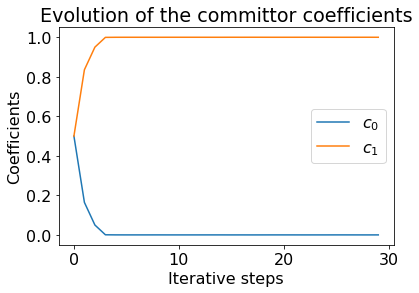

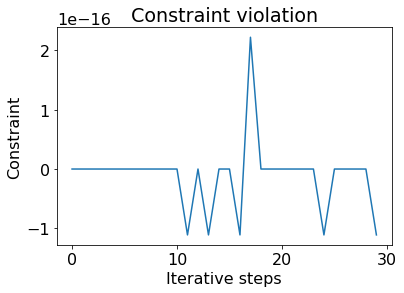

No handles with labels found to put in legend.


Final coefficients
[7.89104760e-04 9.99210895e-01]


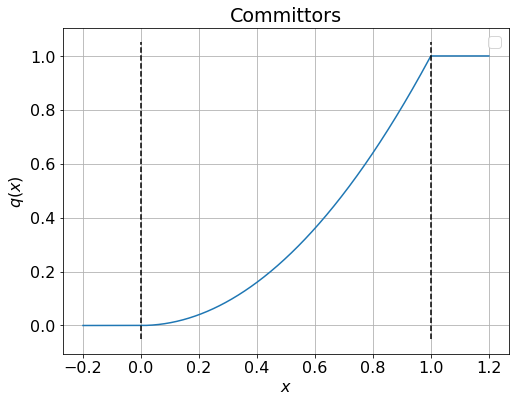

In [68]:
# Self consistent procedure
c = Self_consistent(Guess1 = GUESS1, dGuess1 = DGUESS1, Guess2 = GUESS2, dGuess2 = DGUESS2,c = [0.5, 0.5], kr = KR, KbT = KBT)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure()
plt.plot(c[:,0], label = r"$c_0$")
plt.plot(c[:,1], label = r"$c_1$")
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
plt.figure()
plt.plot(c[:,0]+c[:,1] - 1.0)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    y[i] = c[-1,0]*GUESS1(x[i]) + c[-1,1]*GUESS2(x[i])
plt.plot(x,y)
plt.plot(0.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.title('Committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

### Linear committor as function of KR

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


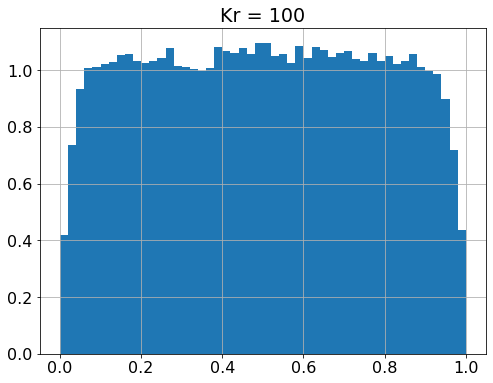

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


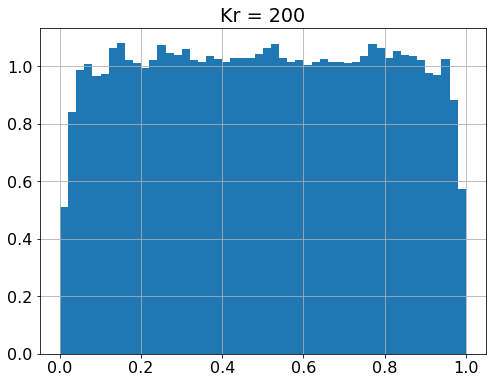

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


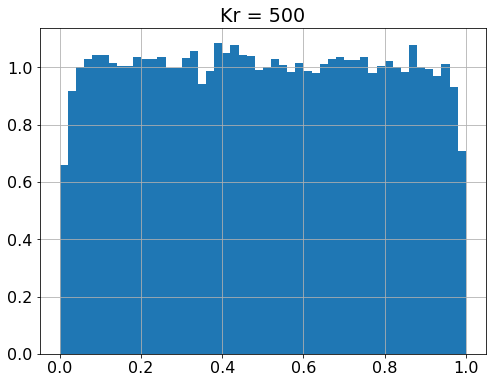

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


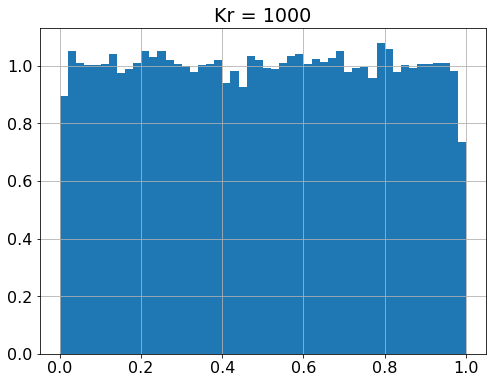

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


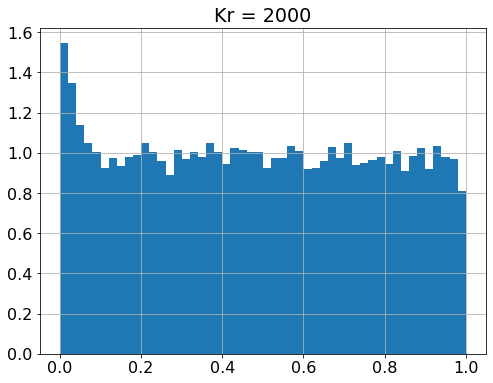

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


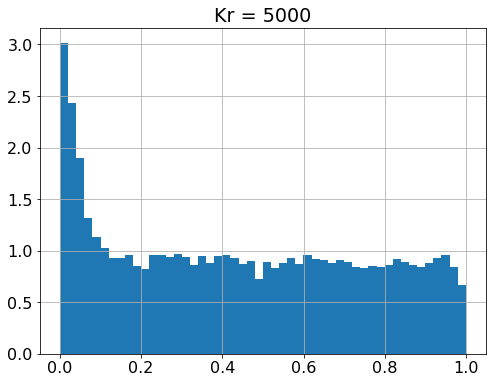

In [59]:
KBT = 0.1
for KR in [100, 200, 500, 1000, 2000, 5000]:
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qLin, dGuess2 = dqLin, c = [1.0,0.0],kr = KR, KbT = KBT)
        if traj[0] != 0:
            if tmp==0:
                trajLin = np.copy(traj)
                tmp = 1
            if tmp==1:
                trajLin = np.concatenate((trajLin, traj), axis=0)
    # Sampling of transition region - histogram plot
    plt.hist(trajLin, 50, density=True)
    plt.title('Kr = '+str(KR))
    plt.grid()
    plt.show()

### Linear committor as function of KBT

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


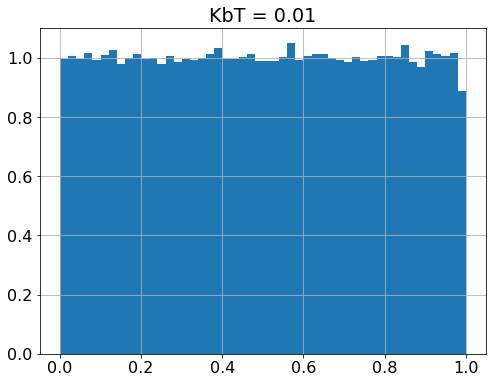

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


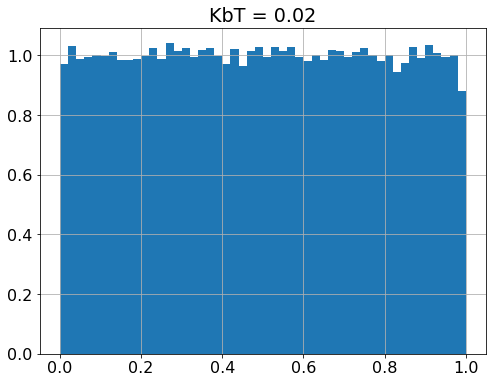

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


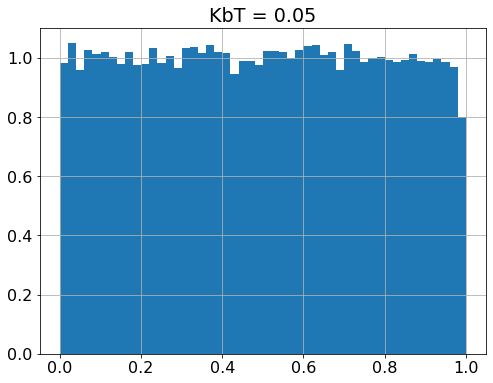

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


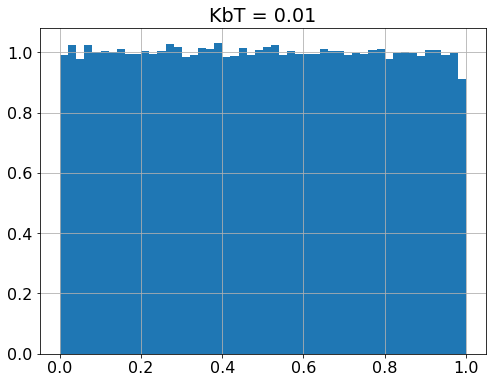

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


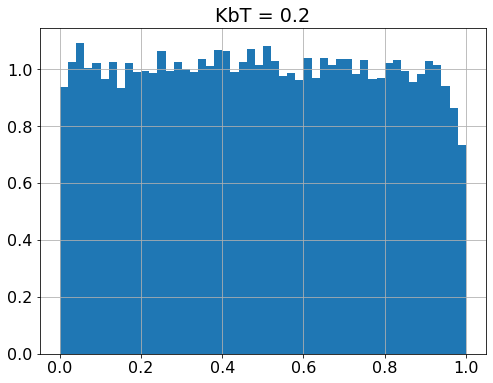

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


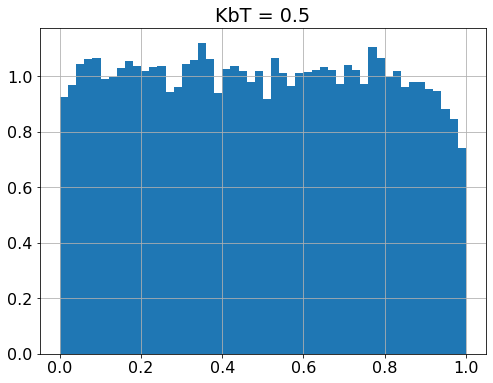

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


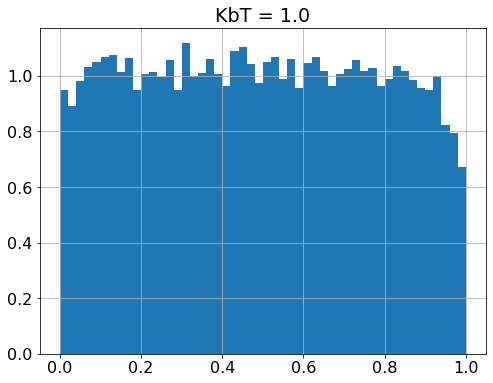

In [60]:
KR = 1000
for KBT in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]:
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qLin, dGuess2 = dqLin, c = [1.0,0.0],kr = KR, KbT = KBT)
        if traj[0] != 0:
            if tmp==0:
                trajLin = np.copy(traj)
                tmp = 1
            if tmp==1:
                trajLin = np.concatenate((trajLin, traj), axis=0)
    # Sampling of transition region - histogram plot
    plt.hist(trajLin, 50, density=True)
    plt.title('KbT = '+str(KBT))
    plt.grid()
    plt.show()

### Quadratic committor as function of KR

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

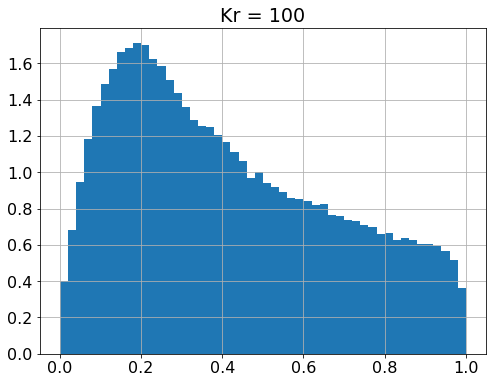

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

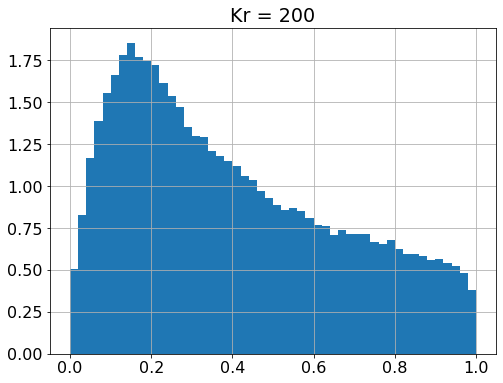

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

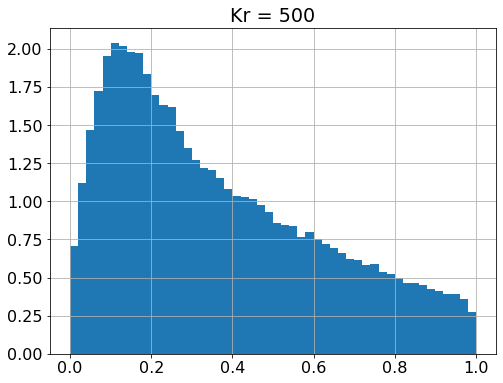

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

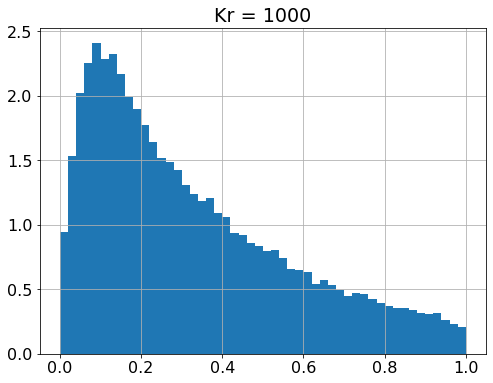

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

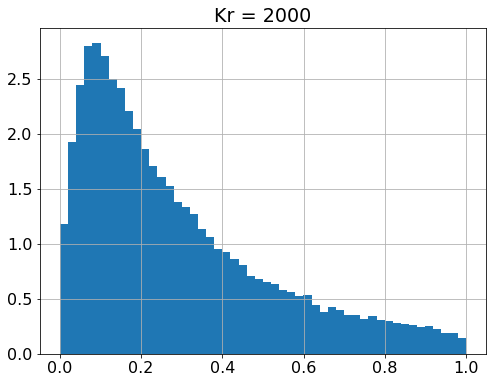

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

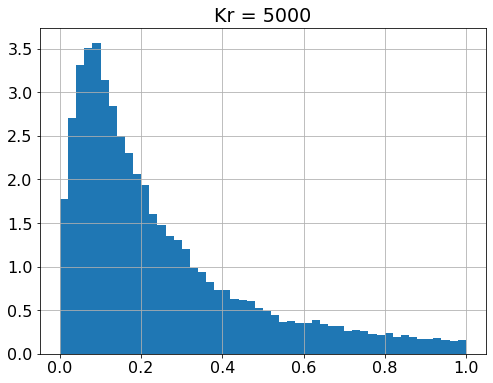

In [61]:
KBT = 0.1
for KR in [100, 200, 500, 1000, 2000, 5000]:
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMD(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, c = [1.0,0.0],kr = KR, KbT = KBT)
        if traj[0] != 0:
            if tmp==0:
                trajQuadr = np.copy(traj)
                tmp = 1
            if tmp==1:
                trajQuadr = np.concatenate((trajQuadr, traj), axis=0)
    # Sampling of transition region - histogram plot
    plt.hist(trajQuadr, 50, density=True)
    plt.title('Kr = '+str(KR))
    plt.grid()
    plt.show()

### Quadratic committor as function of KBT

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

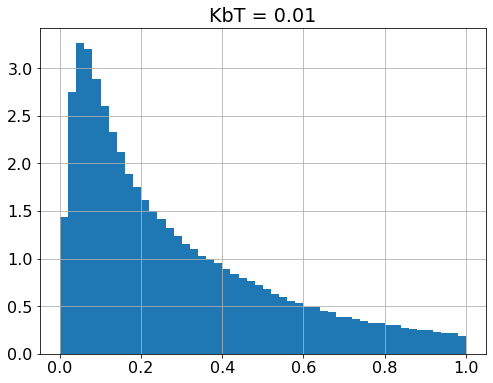

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

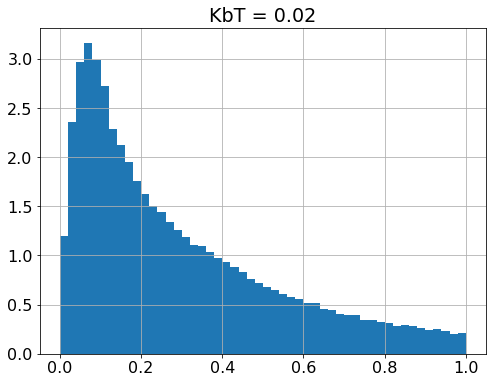

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

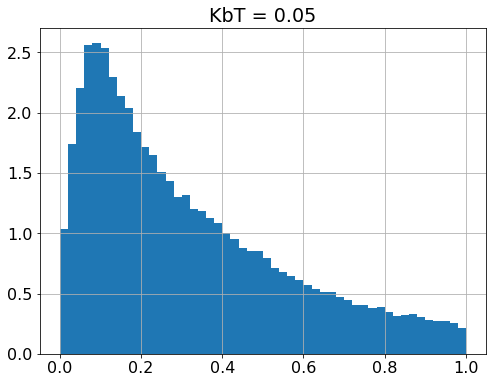

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

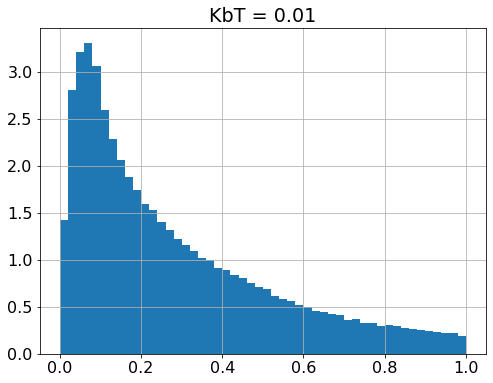

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

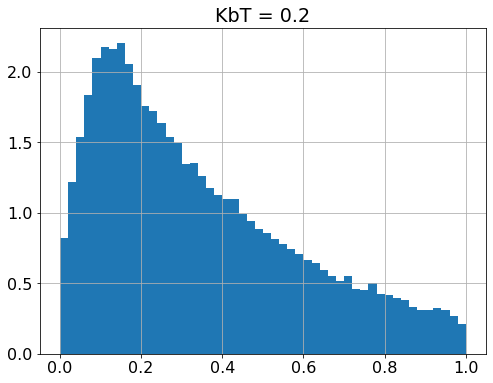

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


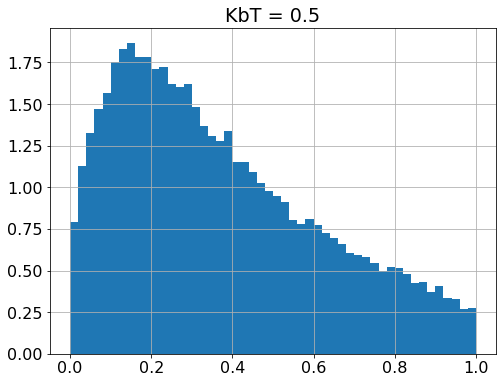

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

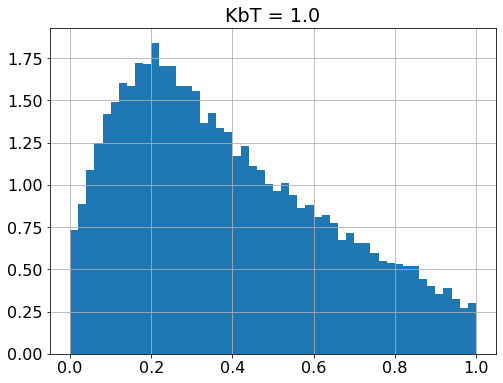

In [63]:
KR = 1000
for KBT in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]:
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMD(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, c = [1.0,0.0],kr = KR, KbT = KBT)
        if traj[0] != 0:
            if tmp==0:
                trajQuadr = np.copy(traj)
                tmp = 1
            if tmp==1:
                trajQuadr = np.concatenate((trajQuadr, traj), axis=0)
    # Sampling of transition region - histogram plot
    plt.hist(trajQuadr, 50, density=True)
    plt.title('KbT = '+str(KBT))
    plt.grid()
    plt.show()

### Fit of quadratic committor

In [71]:
KR = 1000
KBT = 0.01
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, c = [1.0,0.0],kr = KR, KbT = KBT)
    if traj[0] != 0:
        if tmp==0:
            trajQuadr = np.copy(traj)
            tmp = 1
        if tmp==1:
            trajQuadr = np.concatenate((trajQuadr, traj), axis=0)

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

Fit of the histogram

In [112]:
def func(x, a, b, c, d, e):
    return (a*x + b) * np.exp(c * x**2 + d*x + e)

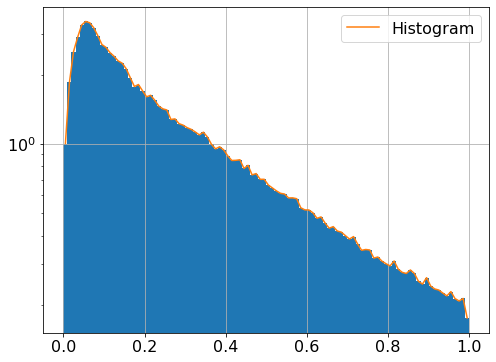

In [116]:
# Sampling of transition region - histogram plot
a = 500
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
n, bins, patches = plt.hist(trajQuadr, 100, density=True)
y = np.zeros_like(n)
for i in range(len(y)):
    y[i] = 0.5*(bins[i]+bins[i+1])
plt.plot(y,n, label = 'Histogram')
plt.yscale('log')
## Fits
#popt, pcov = curve_fit(func, y, n)
#plt.plot(x, func(x, *popt), 'r-',label='fit')
plt.legend()
plt.grid()
plt.show()

In [79]:
print(len(n))
print(len(bins))
print(len(patches))

50
51
50


### Second test: linear potential

In [ ]:
@njit(fastmath=True)
def potential(q):
    k=1.0
    return k*q

@njit(fastmath=True)
def force(q):
    return -k